In [37]:
#@title Imports
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding,  Flatten,GRU, Dense, GlobalAveragePooling1D, Bidirectional, LSTM, Conv1D, GlobalMaxPooling1D, MaxPooling1D, Dropout
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.engine.topology import Layer



In [2]:
#@title Load txt file
corpus = open('/content/drive/My Drive/Text-generation/Data/corpus.txt','rb').read().decode(encoding='utf-8')

In [3]:
#@title Tokenization
tokenizer = Tokenizer()
corpus = corpus.lower().split('\n')
tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index)+1

In [4]:
#@title Define input sequences using texts_to_sequence
input_sequences = []
for line in corpus:
  token_list = tokenizer.texts_to_sequences([line])[0]
  for i in range(1, len(token_list)):
    n_gram_sequence = token_list[:i+1]
    input_sequences.append(n_gram_sequence)

In [5]:
#@title Take max len
max_sequence_len = max([len(x) for x in input_sequences])

In [6]:
#@title Padding to max_len
input_sequences = np.array(pad_sequences(input_sequences,maxlen=max_sequence_len,padding='pre'))

In [7]:
#@title Define X and labels
xs = input_sequences[:,:-1]
labels = input_sequences[:,-1]

In [8]:
#@title Categorise labels one hot encoding
ys = tf.keras.utils.to_categorical(labels,num_classes=total_words)

In [9]:
#@title Bi-directional LSTM
model = Sequential()
model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(150)))
model.add(Dense(total_words, activation='softmax'))
adam = Adam(lr=0.01)
model.compile(loss='categorical_crossentropy',optimizer=adam,metrics=['accuracy'])
history = model.fit(xs,ys,epochs=100,verbose=1)

Epoch 1/100
4240/4240 [==============================] - 14s 3ms/step - loss: 6.4958 - accuracy: 0.0587
Epoch 2/100
4240/4240 [==============================] - 12s 3ms/step - loss: 5.6420 - accuracy: 0.0880
Epoch 3/100
4240/4240 [==============================] - 12s 3ms/step - loss: 4.8673 - accuracy: 0.1373
Epoch 4/100
4240/4240 [==============================] - 12s 3ms/step - loss: 3.8416 - accuracy: 0.2243
Epoch 5/100
4240/4240 [==============================] - 12s 3ms/step - loss: 2.7475 - accuracy: 0.3804
Epoch 6/100
4240/4240 [==============================] - 12s 3ms/step - loss: 1.7937 - accuracy: 0.5599
Epoch 7/100
4240/4240 [==============================] - 12s 3ms/step - loss: 1.1169 - accuracy: 0.7292
Epoch 8/100
4240/4240 [==============================] - 12s 3ms/step - loss: 0.6391 - accuracy: 0.8542
Epoch 9/100
4240/4240 [==============================] - 12s 3ms/step - loss: 0.3846 - accuracy: 0.9139
Epoch 10/100
4240/4240 [==============================] - 11s 3m

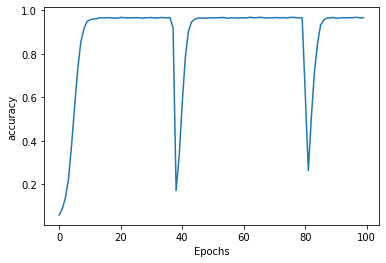

In [10]:
#@title Accuracy vizualisation
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.show()

plot_graphs(history, 'accuracy')


In [28]:
model.save('/content/drive/My Drive/Text-generation/BiLSTM.h5')

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:165: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '


In [24]:
#@title Predict text

def predict_text(seed_text,next_words):
  for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    predicted = model.predict_classes(token_list, verbose=0)
    output_word = ""
    for word, index in tokenizer.word_index.items():
      if index == predicted:
        output_word = word
        break
    seed_text += " " + output_word
  return seed_text

In [25]:
seed_text="wind which was beating the rain in"
next_words = 5
st = predict_text(seed_text,next_words)
print(st)

wind which was beating the rain in pattering drops against the window


In [12]:
corpus

["one winter's evening, towards the close of the year 1800, or within a year\r",
 'or two of that time, a young medical practitioner, recently established in\r',
 'business, was seated by a cheerful fire in his little parlour, listening to the\r',
 'wind which was beating the rain in pattering drops against the window, or\r',
 'rumbling dismally in the chimney. the night was wet and cold; he had\r',
 'been walking through mud and water the whole day, and was now\r',
 'comfortably reposing in his dressing-gown and slippers, more than half\r',
 'asleep and less than half awake, revolving a thousand matters in his\r',
 'wandering imagination. first, he thought how hard the wind was blowing,\r',
 'and how the cold, sharp rain would be at that moment beating in his face,\r',
 'if he were not comfortably housed at home. then, his mind reverted to\r',
 'his annual christmas visit to his native place and dearest friends; he\r',
 'thought how glad they would all be to see him, and how happy it 

In [38]:
class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        """
        Keras Layer that implements an Attention mechanism for temporal data.
        Supports Masking.
        Follows the work of Raffel et al. [https://arxiv.org/abs/1512.08756]
        # Input shape
            3D tensor with shape: `(samples, steps, features)`.
        # Output shape
            2D tensor with shape: `(samples, features)`.
        :param kwargs:
        Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
        The dimensions are inferred based on the output shape of the RNN.
        Example:
            model.add(LSTM(64, return_sequences=True))
            model.add(Attention())
        """
        self.supports_masking = True
        #self.init = initializations.get('glorot_uniform')
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight((input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    def call(self, x, mask=None):
        # eij = K.dot(x, self.W) TF backend doesn't support it

        # features_dim = self.W.shape[0]
        # step_dim = x._keras_shape[1]

        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)), K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())

        # in some cases especially in the early stages of training the sum may be almost zero
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
    #print weigthted_input.shape
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        #return input_shape[0], input_shape[-1]
        return input_shape[0],  self.features_dim

In [40]:
#@title Attention Bi-directional LSTM
model = Sequential()
model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(150,return_sequences=True)))
model.add(Attention(max_sequence_len-1))
model.add(Dense(total_words, activation='softmax'))
adam = Adam(lr=0.01)
model.compile(loss='categorical_crossentropy',optimizer=adam,metrics=['accuracy'])
history = model.fit(xs,ys,epochs=100,verbose=1)

NameError: ignored